# **Intentions:**

*   Picked Assignment 6A Code
*   Add CutOut
*   Use LR Finder to find the best starting learning rate
*   Use SDG with Momentum and Train for 100 Epoch
*   Keep Verbose = 0 (no logs)
*   Printing the top accuracy
*   Show Training and Test Accuracy curves
*   Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.



**# Import Libraries**

In [13]:
import time
import math
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2019) 
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import backend as K

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

import cv2
from keras.preprocessing import image
from google.colab.patches import cv2_imshow

import matplotlib.gridspec as gridspec

Using TensorFlow backend.


### **Define Functions** 

In [0]:
def get_cifar10_data():
    from keras.datasets import cifar10
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
    num_train, img_channels, img_rows, img_cols =  train_features.shape
    num_test, _, _, _ =  test_features.shape
    num_classes = len(np.unique(train_labels))

    # Flatten 32x32x3 images to a 1024*3 vector for each image.
    train_features = train_features.reshape(train_features.shape[0], 32, 32, 3)
    test_features = test_features.reshape(test_features.shape[0], 32, 32, 3)

    train_features = train_features.astype('float32')/255
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    train_labels = np_utils.to_categorical(train_labels, num_classes)
    test_labels = np_utils.to_categorical(test_labels, num_classes)
    return (train_features, train_labels), (test_features, test_labels)

def get_cifar10_labels():
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
    return class_names

def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()
    
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()    
        
# Cut-out
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True):
  
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img

    return eraser
        
# Min-Max scale  
def min_max_scale(X):
    return (X - np.min(X))/(np.max(X)-np.min(X))

### **LR Finder API**

In [0]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K

class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=10,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Negative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than 0")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                    1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 10 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
                1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
                1. - self.loss_smoothing_beta ** self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch_ += 1

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

170500096/170498071 [==============================] - 11s 0us/step


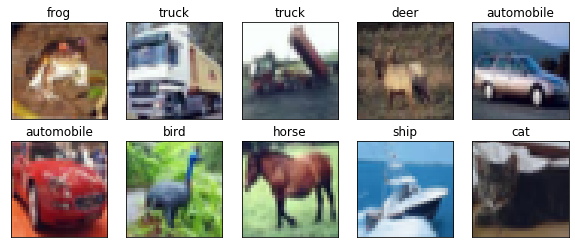

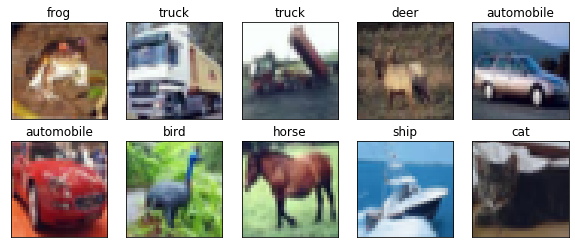

In [16]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

#  load cifar10 data  
(train_features, train_labels), (test_features, test_labels) = get_cifar10_data()

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# prepare an iterators to scale images
train_iterator = datagen.flow(train_features, train_labels, batch_size, shuffle=False)

# calculate mean on training dataset
xyz = datagen.fit(train_features)

train_features, train_labels = train_iterator.next()

train_features = min_max_scale(train_features)

show_examples(train_features[0:10], train_labels[0:10], classes=get_cifar10_labels())

### **Model Architecture**

In [0]:
# Define the model
def build_model(summary=False):

    model = Sequential()
        
    model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(32, 1, 1))
    
    
    model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D(32, 1, 1))
        
    model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(10, 1, 1))
    
    model.add(AveragePooling2D(pool_size = (4,4)))
    model.add(Flatten())
        
    model.add(Activation('softmax'))
    
    sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
  
    model.compile(optimizer= sgd,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])    
    
    #Print model summary
    if (summary == True):
        model.summary()
        i=0
        for layer in model.layers[0:]:
            if "conv" in layer.name:
                print ("Layer No.:", i, " Name:", layer.name)
                i+=1        
    
    return model

In [0]:
def train_network_to_get_lr(model, epochs=1, verbose=2, with_cutout=False):
  
    save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    cutout_fn = get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)

    # Train the model
    start = time.time() 
            
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 preprocessing_function=cutout_fn if with_cutout else None)
    
    datagen_validation = ImageDataGenerator(featurewise_center=True,
                                            featurewise_std_normalization=True)    

    train_iterator      = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=True)
    validation_iterator = datagen_validation.flow(test_features, test_labels, batch_size=batch_size, shuffle=True)
    
    lr_manager = LRFinder(num_samples=len(test_labels), batch_size=batch_size, minimum_lr=0.001, maximum_lr=1) 
                              
    train_history = model.fit_generator(train_iterator,
                                        steps_per_epoch  = len(train_iterator), 
                                        validation_data  = validation_iterator, 
                                        validation_steps = len(validation_iterator),
                                        epochs           = epochs, 
                                        verbose          = verbose,
                                        callbacks        = [save_mcp, lr_manager])    
  
    end = time.time()
    print ("Model took %0.2f seconds to train \n"%(end - start))

    # plot model history
    if (epochs > 1):
        plot_model_history(train_history)

    return train_history

In [0]:
def train_network(model, epochs=25, verbose=2, with_cutout=False, lrate=None):
  
    save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    cutout_fn = get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)

    # Train the model
    start = time.time() 
            
    model.load_weights("best_new_model.h5")
          
    def my_learning_rate(epoch, lrate):
	      return lrate
      
    # learning rate schedule
    def step_decay(epoch, lrate):
        initial_lrate = lrate
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lrate
        
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 preprocessing_function=cutout_fn if with_cutout else None)
    
    datagen_validation = ImageDataGenerator(featurewise_center=True,
                                            featurewise_std_normalization=True)        

    train_iterator      = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=True)
    validation_iterator = datagen_validation.flow(test_features, test_labels, batch_size=batch_size, shuffle=True)
                                  
    train_history = model.fit_generator(train_iterator,
                                        steps_per_epoch  = len(train_iterator), 
                                        validation_data  = validation_iterator, 
                                        validation_steps = len(validation_iterator),
                                        epochs           = epochs, 
                                        verbose          = verbose,
                                        callbacks        = [save_mcp, LearningRateScheduler(step_decay, verbose=1)])    
  
    end = time.time()
    print ("Model took %0.2f seconds to train \n"%(end - start))

    # plot model history
    if (epochs > 1):
        plot_model_history(train_history)

    return train_history

**Build Model**

In [20]:
model = build_model(summary=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: Use




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., pad

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


### **Find Learning Rate**

In [21]:
train_history = train_network_to_get_lr(model, verbose=1, with_cutout=True)



Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - LRFinder: lr = 0.00109260 
1/1 [==============================] - 6s 6s/step - loss: 0.4972 - acc: 0.8719 - val_loss: 0.4572 - val_acc: 0.8685

Epoch 00001: val_acc improved from -inf to 0.86854, saving model to best_new_model.h5
Model took 8.24 seconds to train 

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - LRFinder: lr = 0.00109260 
1/1 [==============================] - 3s 3s/step - loss: 0.4895 - acc: 0.8711 - val_loss: 0.4574 - val_acc: 0.8699

Epoch 00001: val_acc improved from -inf to 0.86994, saving model to best_new_model.h5
Model took 6.68 seconds to train 



### **Learning Rate is 0.00109260**
### **Train the Network for 100 Epoch using identified Learning Rate**


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010926008690148592.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: val_acc improved from -inf to 0.87139, saving model to best_new_model.h5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00002: val_acc improved from 0.87139 to 0.87213, saving model to best_new_model.h5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00003: val_acc improved from 0.87213 to 0.87363, saving model to best_new_model.h5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00004: val_acc improved from 0.87363 to 0.87601, saving model to best_new_model.h5

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00005: val_acc improved from 0.87601 to 0.87778, saving model to best_new_model.h5

Epoch 00006: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00006: val_acc improved from 0.87778 to 0.87969, saving model to best_new_model.h5

Epoch 00007: LearningRateScheduler setting

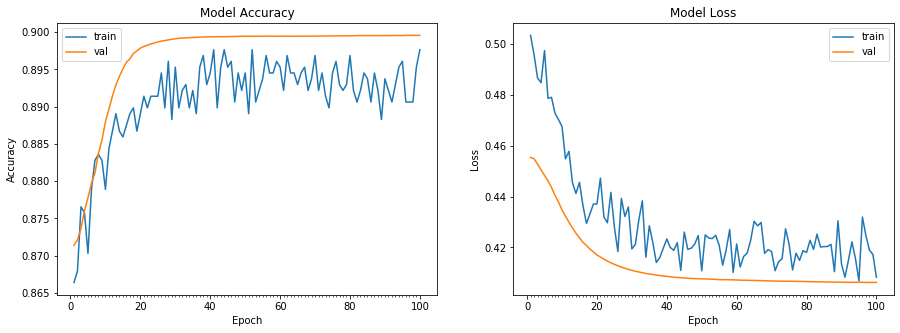

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00001: val_acc improved from -inf to 0.87222, saving model to best_new_model.h5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00002: val_acc improved from 0.87222 to 0.87250, saving model to best_new_model.h5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00003: val_acc improved from 0.87250 to 0.87398, saving model to best_new_model.h5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00004: val_acc improved from 0.87398 to 0.87573, saving model to best_new_model.h5

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00005: val_acc improved from 0.87573 to 0.87788, saving model to best_new_model.h5

Epoch 00006: LearningRateScheduler setting learning rate to 0.0010926008690148592.

Epoch 00006: val_acc improved from 0.87788 to 0.

In [10]:
train_history = train_network(model, epochs=100, verbose=0, with_cutout=True, lrate=0.00109260)

In [0]:
def process_with_gradcam(model, layer, img_t, class_idx, preprocess_func=None, display=True):

    x = np.expand_dims(image.img_to_array(img_t), axis=0)        
    img_t = np.copy(img_t)        
    class_idx = np.argmax(class_idx, axis=0) if type(class_idx)==list or type(class_idx)==np.ndarray else class_idx
    
    if preprocess_func is not None:
       x = preprocess_func(x)    
        
    preds = model.predict(x)  
    preds = np.argmax(preds, axis=1)[0]
    
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)      
    layer_out_channels = last_conv_layer.output_shape[-1]    
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
  
    for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]    
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
  
    heatmap = cv2.resize(heatmap, (img_t.shape[1], img_t.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
    heatmap = heatmap/255
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if heatmap[i][j][1]<=0.01 and heatmap[i][j][2]<=0.01:
                heatmap[i][j] = 0
        
    img_t = (img_t - np.min(img_t))/(np.max(img_t)-np.min(img_t))
    superimposed_img = 0.65*(img_t) + 0.35*heatmap
  
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if np.sum(heatmap[i][j])==0:
                superimposed_img[i][j]=img_t[i][j]
  
    if display:
        plt.imshow(img_t)
        plt.axis("off")
        plt.show()
        plt.imshow(heatmap)
        plt.axis("off")
        plt.show()
        plt.imshow(superimposed_img)
        plt.axis("off")
        plt.show()
        
    return img_t,heatmap,superimposed_img,preds
    
def show_examples_with_gradcam(model, layer, images, labels, classes=None, preprocess_func=None, preprocess_img=None,
                               image_size_multiplier=3,
                               show_actual=True, show_heatmap=False, show_superimposed=True):  
    columns = 5
    rows = int(np.ceil(len(images) / columns))
    labels = np.argmax(labels, axis=1) if type(labels[0])==list or type(labels[0])==np.ndarray else labels
    fig_height = rows * image_size_multiplier * 3
    fig_width = columns * image_size_multiplier
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
    for i in range(rows*columns):
        if i>=len(images):
            break
        x = images[i]
        y = labels[i]

        img,heatmap,superimposed_img,prediction = process_with_gradcam(model,layer,x,y,preprocess_func=preprocess_func,display=False)
        inner = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[i], wspace=0.0, hspace=0.15)
                    
        imgs = [img,heatmap,superimposed_img]
        label = classes[y] if classes is not None else ""
        label = label.split(' ', 1)[0]
        prediction = classes[prediction]
        titles = [("Actual:"+label+" Pred:"+prediction).replace(' ', '\n'),"HeatMap","SuperImposed Image"]
        for j in range(3):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(imgs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(titles[j])
            fig.add_subplot(ax)  
    fig.show()  
    
def find_misclassified(X, y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    misclassified = y_true != y_pred
    X = X[misclassified]
    y_true = y_true[misclassified]
    y_pred = y_pred[misclassified]
    return X, y_true, y_pred
  
def show_misclassified_with_gradcam(model, layer, iterator, classes=None, preprocess_func=None, preprocess_img=None,
                                    image_size_multiplier=3, examples=25,
                                    show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(examples / columns))
    images = []
    labels = []
    predictions = []
    while len(images) < examples:
        batchX, batchY = iterator.next()
        preds = model.predict(batchX)
        X, y_true, y_pred = find_misclassified(batchX, batchY, preds)
        images.extend(X)
        labels.extend(y_true)
        predictions.extend(y_pred)

    images = images[:examples]
    labels = labels[:examples]
    predictions = predictions[:examples]

    show_examples_with_gradcam(model, layer, images, labels, classes=classes, preprocess_func=preprocess_func,
                               preprocess_img=preprocess_img, image_size_multiplier=image_size_multiplier)

### **Identified The 25 Miss-Classified Images with Real Label and the predicted Label**

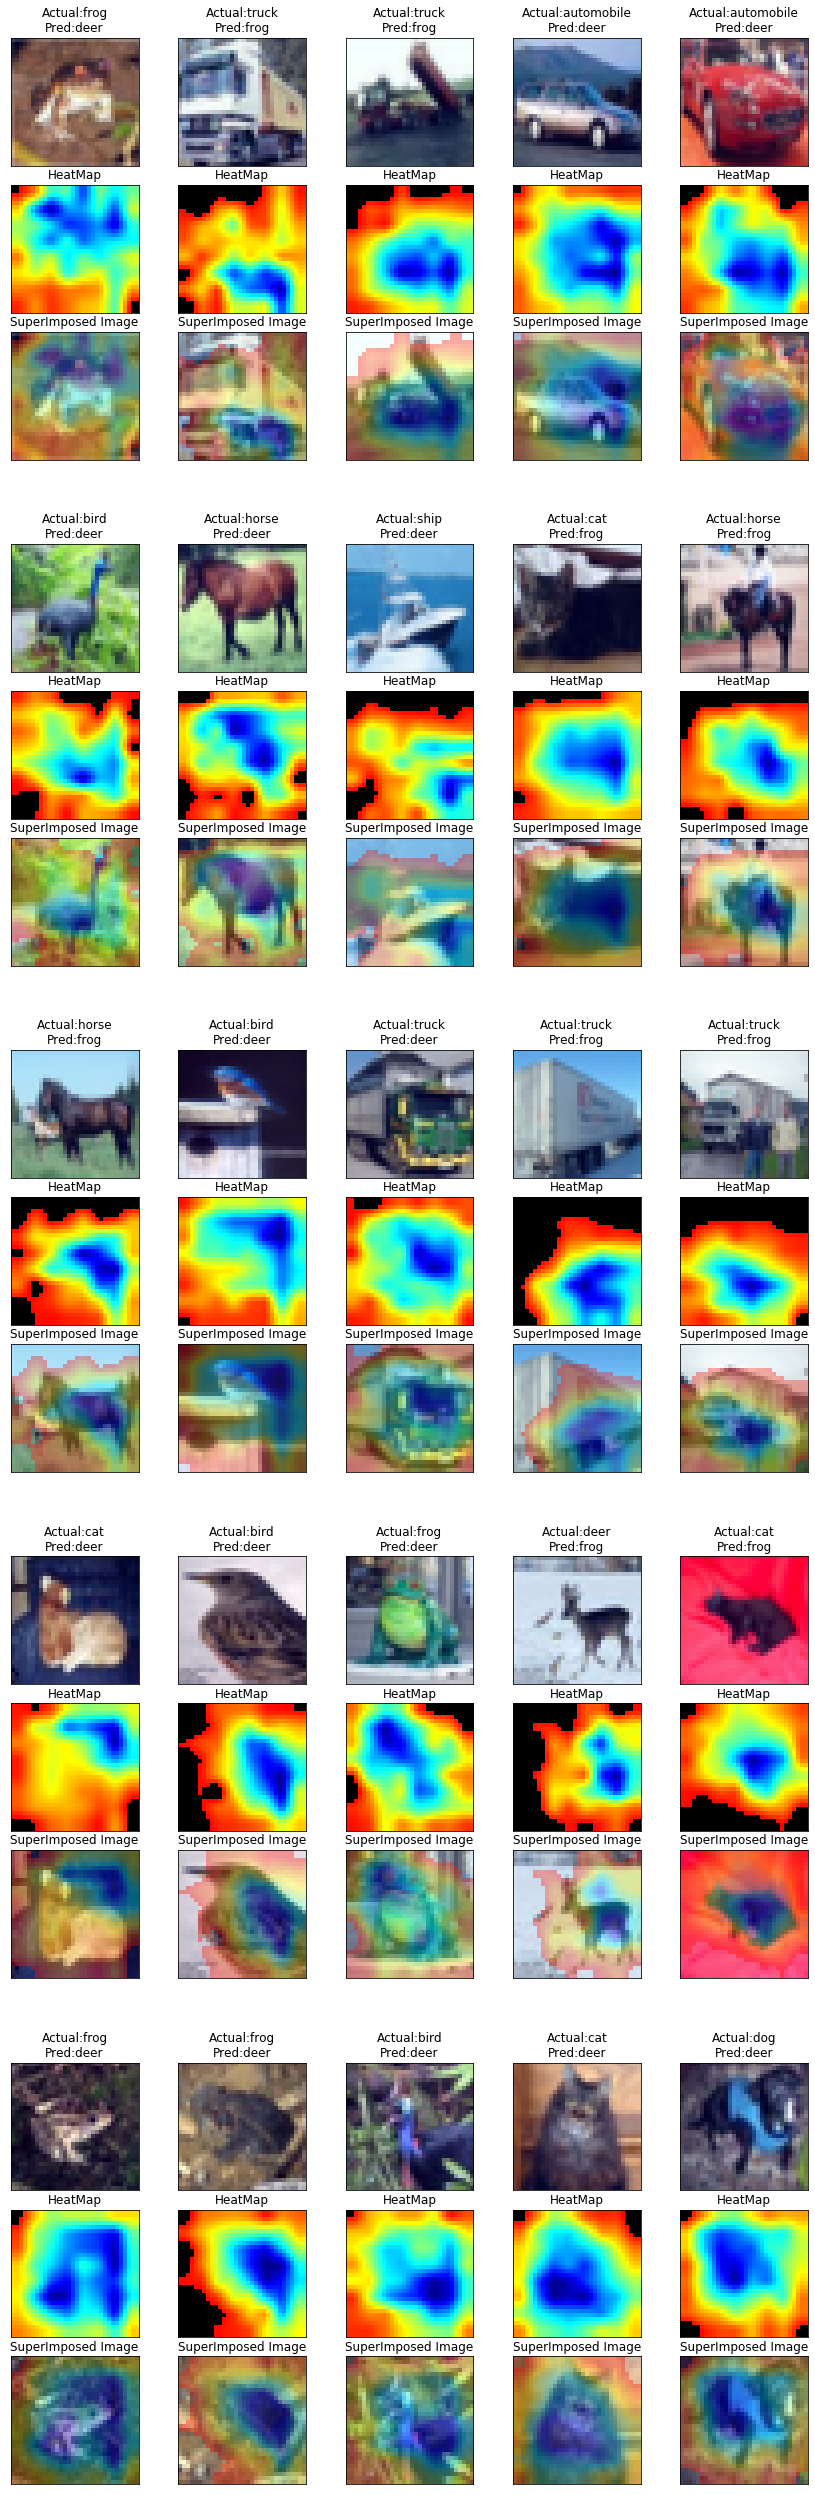

In [12]:
train_iterator      = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=False)
show_misclassified_with_gradcam(model, layer="conv2d_8", iterator=train_iterator, classes=get_cifar10_labels())